In [34]:
import pandas as pd

brain = pd.read_csv("../../data/BrainCancer.csv")
brain

,Unnamed: 0,sex,diagnosis,loc,ki,gtv,stereo,status,time
0,1,Female,Meningioma,Infratentorial,90,6.11,SRS,0,57.64
1,2,Male,HG glioma,Supratentorial,90,19.35,SRT,1,8.98
2,3,Female,Meningioma,Infratentorial,70,7.95,SRS,0,26.46
3,4,Female,LG glioma,Supratentorial,80,7.61,SRT,1,47.80
4,5,Male,HG glioma,Supratentorial,90,5.06,SRT,1,6.30
...,...,...,...,...,...,...,...,...,...
83,84,Male,HG glioma,Supratentorial,80,0.16,SRT,1,20.69
84,85,Male,HG glioma,Supratentorial,80,19.81,SRT,1,6.39
85,86,Male,Meningioma,Supratentorial,90,2.50,SRT,0,32.82
86,87,Male,Meningioma,Supratentorial,90,2.02,SRS,0,42.07


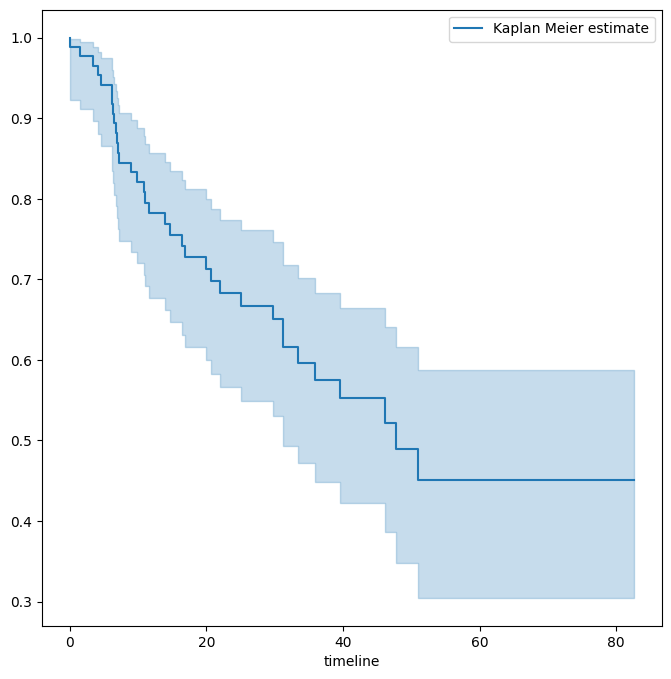

In [35]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))
km = KaplanMeierFitter()
km_brain = km.fit(brain['time'], brain['status'])
km_brain.plot(label='Kaplan Meier estimate', ax=ax);

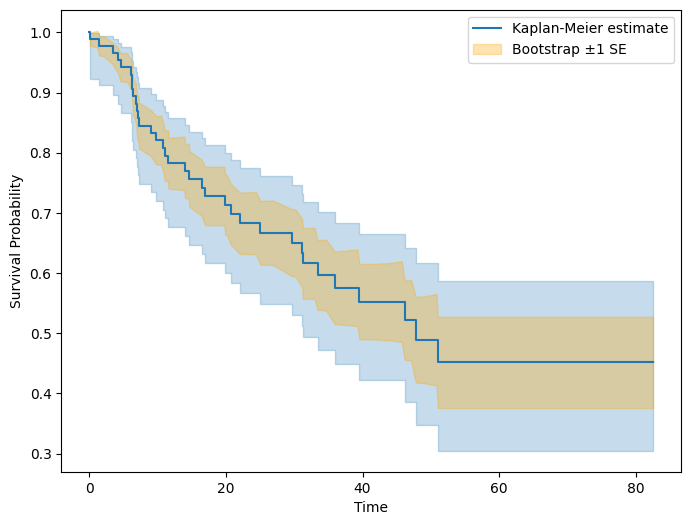

In [36]:
import numpy as np

B = 200
n = len(brain)
time_points = km_brain.survival_function_.index
bootstrap_survival = np.zeros((B, len(time_points)))

for b in range(B):
    sample_indices = np.random.choice(np.arange(n), size=n, replace=True)
    sample = brain.iloc[sample_indices]
    
    km_boot = KaplanMeierFitter()
    km_boot.fit(sample['time'], sample['status'])
    
    bootstrap_survival[b, :] = np.interp(time_points, km_boot.survival_function_.index, 
                                         km_boot.survival_function_['KM_estimate'])
    
bootstrap_se = np.std(bootstrap_survival, axis=0)

fig, ax = plt.subplots(figsize=(8,6))
km_brain.plot_survival_function(ax=ax, label='Kaplan-Meier estimate')
ax.fill_between(time_points, 
                km_brain.survival_function_['KM_estimate'] - bootstrap_se,
                km_brain.survival_function_['KM_estimate'] + bootstrap_se,
                color='orange', alpha=0.3, label='Bootstrap ±1 SE')
ax.set_xlabel("Time")
ax.set_ylabel("Survival Probability")
ax.legend()
plt.show()

In [37]:
from lifelines import CoxPHFitter

brain_encoded = pd.get_dummies(brain, drop_first=True)
cph = CoxPHFitter()
cph.fit(brain_encoded, duration_col='time', event_col='status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 88 total observations, 53 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 88
number of events observed = 35
   partial log-likelihood = -118.36
         time fit was run = 2025-09-13 11:09:53 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                             
Unnamed: 0           -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
ki                   -0.06      0.94      0.02           -0.09           -0.02                0.91                0.98
gtv                   0.04      1.04      0.02           -0.01            0.08                0.99                1.08
sex_Male              0.07      1.07      0.37           -0.65            0.80                0.52                2.22
diagnosis_LG glioma  -1.13      0.32      0.58           -2.27            0.02                0.10                1.02
diagnosis_Meningioma -2.10      0.12      0.46           -2.99           -1.20                0.05                0.30
diagnosis_Other      -1.24      0.29      0.63           -2.48           -0.01                0.08                0.99
loc_Supratentorial    0.37      1.45      0.70           -1.00            1.74                0.37                5.67
stereo_SRT            0.15      1.16      0.60           -1.02            1.32                0.36                3.75

                      cmp to     z      p  -log2(p)
covariate                                          
Unnamed: 0              0.00 -0.33   0.74      0.44
ki                      0.00 -3.13 <0.005      9.17
gtv                     0.00  1.58   0.11      3.14
sex_Male                0.00  0.19   0.85      0.24
diagnosis_LG glioma     0.00 -1.93   0.05      4.23
diagnosis_Meningioma    0.00 -4.57 <0.005     17.68
diagnosis_Other         0.00 -1.97   0.05      4.36
loc_Supratentorial      0.00  0.53   0.60      0.74
stereo_SRT              0.00  0.25   0.80      0.32
---
Concordance = 0.79
Partial AIC = 254.71
log-likelihood ratio test = 39.58 on 9 df
-log2(p) of ll-ratio test = 16.76

The Cox proportional hazards model was fit using the **lifelines.CoxPHFitter** on 88 observations with 35 observed events, using **time** as the duration column and **status** as the event column, with baseline hazards estimated by the Breslow method. The model achieved a partial log-likelihood of -118.36 and a concordance of 0.79, indicating good discriminatory ability. Among the covariates, **ki** showed a statistically significant negative association with hazard (HR = 0.94, 95% CI: 0.91–0.98, p < 0.005), indicating that higher **ki** values were associated with lower risk. Tumor volume (**gtv**) had a modest, non-significant positive effect (HR = 1.04, p = 0.11). Male sex was not significantly associated with survival (HR = 1.07, p = 0.85). Compared to the baseline diagnosis (likely glioblastoma or reference group), LG glioma, meningioma, and other diagnoses were associated with lower hazards, with meningioma showing the strongest effect (HR = 0.12, p < 0.005). Tumor location in the supratentorial region and treatment with SRT (stereo\_SRT) were not statistically significant. The overall log-likelihood ratio test for the model was highly significant (χ² = 39.58 on 9 df, p ≪ 0.001), supporting that the set of predictors collectively explains variation in survival. The model’s partial AIC was 254.71.

This summary highlights that **ki** and certain diagnosis types are the most influential predictors of survival in this dataset.

In [38]:
import pandas as pd

# Combine ki==40 with ki==60
brain['ki_strata'] = brain['ki'].replace({40: 60})

In [45]:
from lifelines import CoxPHFitter

brain_encoded = pd.get_dummies(brain, drop_first=True)

cph_strat = CoxPHFitter(penalizer=0.1)
cph_strat.fit(brain_encoded, duration_col='time', event_col='status', strata=['ki_strata'])
cph_strat.print_summary()

model,lifelines.CoxPHFitter
duration col,'time'
event col,'status'
penalizer,0.1
l1 ratio,0.0
strata,ki_strata
baseline estimation,breslow
number of observations,88
number of events observed,35
partial log-likelihood,-80.93
time fit was run,2025-09-13 11:11:28 UTC
